In [1]:
#Gra    ph Dists
from graph_distances.competing_methods import getEVdist, getDegreedist, getG2V_dist, getNodeEmbeddingdist, getGOT
from our_external_pypi_package.prob_OT import getOT,cnp#,indicator_matrix_from_colors

#Benchmark
from benchmark import knn
import time

#Plotting
from tools.plotting import plot_heatmap, hier_clustering, plot_emb
import seaborn as sns
import matplotlib.pyplot as plt

#External Packages
import networkx as nx
import numpy as np
import pandas as pd
import random
    


from sklearn.mixture import GaussianMixture
#from klgmr import mixture_reduction
import seaborn as sns
from sklearn.mixture import BayesianGaussianMixture
from scipy.spatial.distance import pdist, cdist
from scipy.optimize import linear_sum_assignment
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from numpy.linalg import inv
import umap
import pandas as pd
from sklearn.manifold import TSNE
from sklearn import manifold

from pydiffmap import diffusion_map


from scipy.spatial.distance import squareform
from matplotlib.patches import Patch
import pathlib

import random

%load_ext autoreload
%autoreload 2

/home/kuehn/anaconda3/envs/mamba/envs/GMM2OT/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/kuehn/anaconda3/envs/mamba/envs/GMM2OT/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/kuehn/anaconda3/envs/mamba/envs/GMM2OT/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument

In [2]:
def name2label_detailed(name):
    if "CK159" in name or "CK366" in name: # or "CK368" in name:
        #159 is myogenic in anndata
        #return "Myogenic"  
        return "Young Fibrotic"
    if "IZ" in name:
        return "Ischemic"
    elif "BZ" in name:
        return "Border"
    elif "FZ" in name:
        return "Fibrotic"
    elif "control" in name:
        return "Control" #"Myogenic"
    elif "RZ" in name:
        return "Myogenic"

    else:
        return "Unknown"
    
def name2label(name):
    if "CK159" in name: #or "CK366" in name: # or "CK368" in name:
        #159 is myogenic in anndata
        return "Myogenic"  
        #return "Young Fibrotic"
    if "IZ" in name:
        return "Ischemic"
    #elif "BZ" in name:
    #    return "Border"
    elif "FZ" in name:
        return "Fibrotic"
    elif "control" in name:
        return "Myogenic"
    elif "RZ" in name:
        return "Myogenic"

    else:
        return "Unknown"
    
label_order= ["Myogenic","Ischemic","Fibrotic"]
#label_order= ["Control","Myogenic","Border","Ischemic","Young Fibrotic","Fibrotic"]

In [3]:
#path = pathlib.Path("/home/kuehn/G4P/data/myocardial_infarction/multilayer/single_cell_level/scRNA/sc2sc/100knn") #_gaussian_kernel") #full_npy") #
path_graph = pathlib.Path("/home/kuehn/G4P/data/myocardial_infarction/multilayer/single_cell_level/scRNA/sc_coLocs")
path_feat = pathlib.Path("/home/kuehn/G4P/data/myocardial_infarction/multilayer/single_cell_level/scRNA/sc_RNA_feature")
annotation_image_path = "/home/kuehn/G4P/data/myocardial_infarction/multilayer/single_cell_level/scRNA_corrected_labels/histoslides/"
annotation_niches_path = "/home/kuehn/G4P/data/myocardial_infarction/multilayer/single_cell_level/scRNA_corrected_labels/nicheslides/"

graphs = []
features = []
labels = []
patient_ids = []
annotation_image_paths = []
annotation_niches_paths = []

#for patient_folder in pathlib.Path(path).iterdir():
for sample, feats in zip(sorted(pathlib.Path(path_graph).iterdir()),sorted(pathlib.Path(path_feat).iterdir())):
    print(sample)
    print(feats)


    if "npy" in str(sample.suffix) :
        graph = np.load(sample)
        #graph = nx.from_numpy_array(arr)
    elif "csv" in str(sample.suffix) :
        df = pd.read_csv(sample,index_col=0)
        graph = nx.from_pandas_adjacency(df)
    else:
        continue 

    graphs.append(graph)
    features.append(np.load(feats))
    labels.append(name2label(str(sample.stem)))
    patient_ids.append(str(sample.stem)[:5])
    annotation_image_paths.append(annotation_image_path+"VIS"+str(sample.stem)[2:5]+".jpg")
    annotation_niches_paths.append(annotation_niches_path+"VIS"+str(sample.stem)[2:5]+".png")

print(list(zip(patient_ids,labels)))

/home/kuehn/G4P/data/myocardial_infarction/multilayer/single_cell_level/scRNA/sc_coLocs/CK158_control_P1_coLocs.npy
/home/kuehn/G4P/data/myocardial_infarction/multilayer/single_cell_level/scRNA/sc_RNA_feature/CK158_control_P1_scRNA.npy
/home/kuehn/G4P/data/myocardial_infarction/multilayer/single_cell_level/scRNA/sc_coLocs/CK159_RZ_FZ_P5_coLocs.npy
/home/kuehn/G4P/data/myocardial_infarction/multilayer/single_cell_level/scRNA/sc_RNA_feature/CK159_RZ_FZ_P5_scRNA.npy
/home/kuehn/G4P/data/myocardial_infarction/multilayer/single_cell_level/scRNA/sc_coLocs/CK160_RZ_BZ_P3_coLocs.npy
/home/kuehn/G4P/data/myocardial_infarction/multilayer/single_cell_level/scRNA/sc_RNA_feature/CK160_RZ_BZ_P3_scRNA.npy
/home/kuehn/G4P/data/myocardial_infarction/multilayer/single_cell_level/scRNA/sc_coLocs/CK163_RZ_BZ_P2_coLocs.npy
/home/kuehn/G4P/data/myocardial_infarction/multilayer/single_cell_level/scRNA/sc_RNA_feature/CK163_RZ_BZ_P2_scRNA.npy
/home/kuehn/G4P/data/myocardial_infarction/multilayer/single_cell_le

In [4]:
threshold = False

if threshold:

    threshold_cells = 2000
    del_index = []

    for i,graph in enumerate(graphs):
        if len(graph) < threshold_cells:
            print(labels[i])
            print(i)
            del_index.append(i)

    graphs = np.delete(np.array(graphs,dtype=object),del_index).tolist()
    features = np.delete(np.array(features,dtype=object),del_index).tolist()
    labels = np.delete(np.array(labels,dtype=object),del_index).tolist()

In [5]:
balance = False

if balance:
    unique, inds, counts = np.unique(labels, return_counts=True, return_index=True)
    unique = [labels[index] for index in sorted(inds)]
    n = np.min(counts)
    old_graphs, old_labels, old_conds, old_phase = graphs,np.asarray(labels),np.asarray(cond),np.asarray(phase)
    graphs, labels, cond, phase= [],[],[],[]
    for label in unique:
        inds = np.nonzero(old_labels==label)[0]
        random.shuffle(inds)
        graphs.extend([old_graphs[i] for c,i in enumerate(inds) if c < n])
        labels.extend(old_labels[inds][:n])
        cond.extend(old_conds[inds][:n])
        phase.extend(old_phase[inds][:n])

len(graphs[0])

3429

In [6]:
def plot_table(df,tranpose=False):
    format_df = df
    #format_df.set_index('method',inplace=True)
    if tranpose:
        format_df = format_df.transpose()
    display(format_df)
    print(format_df.to_latex(index=True,
                  #formatters={"name": str.upper},
                  float_format="{:.2f}".format,
    ))

cells_n = {}

for label, graph in zip(labels,graphs):
    cells_n[label] = cells_n.get(label,[]) + [len(graph)]

print(cells_n)


cells_avg_std = {label: f"{np.average(ns):.1f}±{np.std(ns):.1f}" for label,ns in cells_n.items()}  
cells_min = {label: np.amin(ns) for label,ns in cells_n.items()}
cells_max = {label: np.amax(ns) for label,ns in cells_n.items()}

formated_dict = {"Mean±Std":list(cells_avg_std.values()),"Min": list(cells_min.values()),"Max": list(cells_max.values())}
print(formated_dict )
df = pd.DataFrame(formated_dict ,index=cells_avg_std.keys())
df = df.reindex(["Myogenic","Control","Ischemic","Fibrotic"])
print(df)

{'Myogenic': [3429, 2910, 2621, 2785, 2819, 3210, 2804, 3143, 2825, 3743, 1817, 1872, 2744], 'Ischemic': [1585, 1013, 1393, 1009, 1393], 'Fibrotic': [2638, 1547, 1755, 945]}
{'Mean±Std': ['2824.8±514.3', '1278.6±229.5', '1721.2±607.1'], 'Min': [1817, 1009, 945], 'Max': [3743, 1585, 2638]}
              Mean±Std     Min     Max
Myogenic  2824.8±514.3  1817.0  3743.0
Control            NaN     NaN     NaN
Ischemic  1278.6±229.5  1009.0  1585.0
Fibrotic  1721.2±607.1   945.0  2638.0


In [7]:
#Params for CNP and CBB
i = 200
k = 20
d = 10
D = 5

precomputed_dists = {}
plans = {}
times = {}
struct_cost = {}
feat_cost = {}

n_cpus = 22

path = "/home/kuehn/G4P_clean/2024-fused-wasserstein-multimodal-graph-optimal-transport-based-on-probabilistic-node-embeddings-with-application-in-genomics-and-transcriptomics/data/results/" 
save_name = "myocard_graphs_maybefinal" 

#Loading functs
def tri_to_flat(tri_matrix):
    n = tri_matrix.shape[0]
    list = tri_matrix[np.triu_indices(n)].flatten()
    return list

def flat_to_tri(list):
    n = int(0.5 * (np.sqrt(8 * len(list) + 1) -1)) #Solves len(flat)= N(N+1)/2 for N
    tri_matrix = np.zeros((n,n))
    ind = np.triu_indices(n)
    tri_matrix[ind] = np.array(list)
    return tri_matrix

load = True
if load:
    #if input(f"Currently loading is set to {load}, please confirm that you want to overwrite variables") =='':
    precomputed_dists =  np.load(path+save_name+"dists.npy",allow_pickle=True).tolist() 
    times =np.load(path+save_name+"times.npy",allow_pickle=True).tolist() 
    labels = np.load(path+save_name+"labels.npy",allow_pickle=True).tolist() 
    patient_ids = np.load(path+save_name+"patientid.npy",allow_pickle=True).tolist() 

#save_name = "coloc+scRNa_FW_"  
print(precomputed_dists.keys())

dict_keys(['FusedWasserstein', 'Role2vec-FGW', 'Node2Vec-FGW', 'CNP', 'CCB', 'Role2vec-GW', 'Node2Vec-GW', 'scRNA-Wasserstein'])


In [8]:
from FusedWasserstein import fw

cnp_emb = getOT(graphs,None,None,i_instatiations=i, k_colors=k, d_depth=d, D_dimensions=None, normalized=True, row_normalized=True, sort=True, alpha=1.0,num_workers=n_cpus,embedding_only=True)
ccb_emb = getOT(graphs,None,None,i_instatiations=i, k_colors=k, d_depth=d, D_dimensions=None, normalized=True, row_normalized=True, sort=False, alpha=1.0,num_workers=n_cpus,embedding_only=True)

KeyboardInterrupt: 

In [8]:
%load_ext autoreload
%autoreload 2
methods =  {
    
    #"FW_1/4CNP_1/4CCB_1/2RNA": (lambda G1,G2,feats: fw(embeddings=[cnp_emb,ccb_emb],features=[features],return_plans=True,threads=n_cpus,alpha=[1/24,1/4],beta=[1/2])),
    "FusedWasserstein": (lambda G1,G2,feats: fw(embeddings=[cnp_emb,ccb_emb],features=[features],return_plans=True,threads=n_cpus,alpha=[1/3,1/3],beta=[1/3])),
    #"FusedWasserstein_0.5": (lambda G1,G2,feats: fw(embeddings=[cnp_emb,ccb_emb],features=[features],return_plans=True,threads=n_cpus,alpha=[1/2,1/2],beta=[1/4])),
    
    
    "Role2vec-FGW":(lambda G1,G2, feats: getOT(G1,G2,feats, k_colors=k, d_depth=d, D_dimensions=None, normalized=True, row_normalized=True, sort=False, alpha=0.5,num_workers=n_cpus,embedding_method="role2vec",distance='fgw')),
    "Node2Vec-FGW":(lambda G1,G2, feats: getOT(G1,G2,feats, k_colors=k, d_depth=d, D_dimensions=None, normalized=True, row_normalized=True, sort=False, alpha=0.5,num_workers=n_cpus,embedding_method="node2vec",distance='fgw')),


    "CNP": (lambda G1,G2,feats: fw(embeddings=[cnp_emb],features=[features],return_plans=True,threads=n_cpus,alpha=[1],beta=[0])),
    "CCB": (lambda G1,G2,feats: fw(embeddings=[ccb_emb],features=[features],return_plans=True,threads=n_cpus,alpha=[1],beta=[0])),
    "Role2vec-GW":(lambda G1,G2, feats: getOT(G1,G2,None, k_colors=k, d_depth=d, D_dimensions=None, normalized=True, row_normalized=True, sort=False, alpha=1.,num_workers=n_cpus,embedding_method="role2vec",distance='gw')),
    "Node2Vec-GW":(lambda G1,G2, feats: getOT(G1,G2,None, k_colors=k, d_depth=d, D_dimensions=None, normalized=True, row_normalized=True, sort=False, alpha=1.,num_workers=n_cpus,embedding_method="node2vec",distance='gw')),

    "scRNA-Wasserstein": (lambda G1,G2,feats: fw(embeddings=[cnp_emb,ccb_emb],features=[features],return_plans=True,threads=n_cpus,alpha=[0,0],beta=[1])),

    










    #Euclidean Dists
    #"Degree": (lambda G1,G2, feats: getDegreedist(G1,G2)),
    #"EV": (lambda G1,G2, feats: getEVdist(G1,G2)),
    #"Graph2Vec": (lambda G1,G2, feats: getG2V_dist(G1,G2, dim=(64 * k * d))),
    #"CCB-TiedW_a0 (genexp only)": (lambda G1,G2, feats: getOT(G1,G2,feats,i_instatiations=i, k_colors=k, d_depth=d, D_dimensions=None, normalized=True, row_normalized=True, sort=False, alpha=0.,num_workers=n_cpus )),
    #"CCB-TiedW_a0.25": (lambda G1,G2, feats: getOT(G1,G2,feats,i_instatiations=i, k_colors=k, d_depth=d, D_dimensions=None, normalized=True, row_normalized=True, sort=False, alpha=0.25,num_workers=n_cpus )),
    #"CCB-TiedW_a0.5": (lambda G1,G2, feats: getOT(G1,G2,feats,i_instatiations=i, k_colors=k, d_depth=d, D_dimensions=None, normalized=True, row_normalized=True, sort=False, alpha=0.5,num_workers=n_cpus )),
    #"CCB-TiedW_a0.75": (lambda G1,G2, feats: getOT(G1,G2,feats,i_instatiations=i, k_colors=k, d_depth=d, D_dimensions=None, normalized=True, row_normalized=True, sort=False, alpha=0.75,num_workers=n_cpus )),
    #"CCB-TiedW_a1 (spatial only)": (lambda G1,G2, feats: getOT(G1,G2,feats,i_instatiations=i, k_colors=k, d_depth=d, D_dimensions=None, normalized=True, row_normalized=True, sort=False, alpha=1.,num_workers=n_cpus )),
    
    
    #"CCB-TiedW2k2d": (lambda G1,G2, feats: getOT(G1,G2,feats,i_instatiations=i*2, k_colors=2*k, d_depth=2*d, D_dimensions=None, normalized=True, row_normalized=True, sort=False, num_workers=n_cpus )),
    #"CCB-TiedW4k2d": (lambda G1,G2, feats: getOT(G1,G2,feats,i_instatiations=i*4, k_colors=2*k, d_depth=2*d, D_dimensions=None, normalized=True, row_normalized=True, sort=False, num_workers=n_cpus )),

    #Gromov-Wasserstein Dists
    #"Node2Vec-GW":(lambda G1,G2, feats: getNodeEmbeddingdist(G1, G2, embedding_name='node2vec', D_dimensions=(k * d),distance='gw')),


    #"Role2vec-FGW_RNA":(lambda G1,G2, feats: getOT(G1,G2,feats, k_colors=k, d_depth=d, D_dimensions=None, normalized=True, row_normalized=True, sort=False, alpha=0,num_workers=n_cpus,embedding_method="role2vec",distance='fgw')),
    
    #"Role2vec-GW":(lambda G1,G2, feats: getOT(G1,G2,feats, k_colors=k, d_depth=d, D_dimensions=None, normalized=True, row_normalized=True, sort=False, alpha=1,num_workers=n_cpus,embedding_method="role2vec",distance='gw')),
    #"Node2Vec-FGW_RNA":(lambda G1,G2, feats: getOT(G1,G2,feats, k_colors=k, d_depth=d, D_dimensions=None, normalized=True, row_normalized=True, sort=False, alpha=0,num_workers=n_cpus,embedding_method="node2vec",distance='fgw')),
    
    #"Node2Vec-GW":(lambda G1,G2, feats: getOT(G1,G2,feats, k_colors=k, d_depth=d, D_dimensions=None, normalized=True, row_normalized=True, sort=False, alpha=1,num_workers=n_cpus,embedding_method="node2vec",distance='gw')),

    #Wasserstein Dists.
    #"GOT": (lambda G1,G2: getGOT(G1,G2,dist='GOT')),
    #"CNP-TiedW": (lambda G1,G2, feats: getOT(G1,G2,i_instatiations=i, k_colors=k, d_depth=d, D_dimensions=None,num_workers=n_cpus )), 
    #"CCB-TiedW": (lambda G1,G2, feats: getOT(G1,G2,i_instatiations=i, k_colors=k, d_depth=d, D_dimensions=None, normalized=True, row_normalized=True, sort=False, num_workers=n_cpus )),
    #"CNP-ScaledW": (lambda G1,G2, feats: getOT(G1,G2,i_instatiations=i, k_colors=k, d_depth=d, D_dimensions=None,num_workers=n_cpus ,covariance='scaled')), 
    #"CCB-ScaledW": (lambda G1,G2, feats: getOT(G1,G2,i_instatiations=i, k_colors=k, d_depth=d, D_dimensions=None, normalized=True, row_normalized=True, sort=False, num_workers=n_cpus ,covariance='scaled')),
    #"CNP-FullW": (lambda G1,G2, feats: getOT(G1,G2,i_instatiations=i, k_colors=k, d_depth=d, D_dimensions=20,num_workers=n_cpus ,covariance='full')), 
    #"CCB-FullW": (lambda G1,G2, feats: getOT(G1,G2,i_instatiations=i, k_colors=k, d_depth=d, D_dimensions=20, normalized=True, row_normalized=True, sort=False, num_workers=n_cpus ,covariance='full')),


    }



#methods.update({
#    f"CCB-TiedW_a{a:.2f}": (lambda G1,G2, feats,alpha=a: getOT(G1,G2,feats,i_instatiations=i, k_colors=k, d_depth=d, D_dimensions=None, normalized=True, row_normalized=True, sort=False, alpha=alpha,num_workers=n_cpus,scale_multiple_costs="mean_dist" )) for a in np.linspace(0,1,num=3)    
#})

#methods.update({
#    f"CNP-TiedW_a{a:.2f}": (lambda G1,G2, feats,alpha=a: getOT(G1,G2,feats,i_instatiations=i, k_colors=k, d_depth=d, D_dimensions=None, normalized=True, row_normalized=True, sort=True, alpha=alpha,num_workers=n_cpus,scale_multiple_costs="mean_dist" )) for a in np.linspace(0,1,num=3)
#})




'''
methods= {
    "CNP-TiedW_a0.5_emb_mean": (lambda G1,G2, feats: getOT(G1,G2,feats,i_instatiations=i, k_colors=k, d_depth=d, D_dimensions=None, normalized=True, row_normalized=True, sort=True, alpha=0.5,num_workers=n_cpus )),   
    "CCB-TiedW_a0.5_emb_mean": (lambda G1,G2, feats: getOT(G1,G2,feats,i_instatiations=i, k_colors=k, d_depth=d, D_dimensions=None, normalized=True, row_normalized=True, sort=False, alpha=0.5,num_workers=n_cpus )),

    "CNP-TiedW_a0.5_dist_mean": (lambda G1,G2, feats: getOT(G1,G2,feats,i_instatiations=i, k_colors=k, d_depth=d, D_dimensions=None, normalized=True, row_normalized=True, sort=True, alpha=0.5,num_workers=n_cpus,scale_multiple_costs="dist_mean")),   
    "CCB-TiedW_a0.5_dist_mean": (lambda G1,G2, feats: getOT(G1,G2,feats,i_instatiations=i, k_colors=k, d_depth=d, D_dimensions=None, normalized=True, row_normalized=True, sort=False, alpha=0.5,num_workers=n_cpus,scale_multiple_costs="dist_mean" )),

    "CNP-TiedW_a0.5_emb_norm": (lambda G1,G2, feats: getOT(G1,G2,feats,i_instatiations=i, k_colors=k, d_depth=d, D_dimensions=None, normalized=True, row_normalized=True, sort=True, alpha=0.5,num_workers=n_cpus,scale_multiple_costs="norm")),   
    "CCB-TiedW_a0.5_emb_norm": (lambda G1,G2, feats: getOT(G1,G2,feats,i_instatiations=i, k_colors=k, d_depth=d, D_dimensions=None, normalized=True, row_normalized=True, sort=False, alpha=0.5,num_workers=n_cpus,scale_multiple_costs="norm" )),
}
'''

    
#methods= {
#    f"CCB-TiedW_a{alpha:.2f}": (lambda G1,G2, feats: getOT(G1,G2,feats,i_instatiations=i, k_colors=k, d_depth=d, D_dimensions=None, normalized=True, row_normalized=True, sort=False, alpha=alpha,num_workers=n_cpus )) for alpha in np.linspace(0,1,num=11),   
#    f"CNP-TiedW_a{alpha:.2f}": (lambda G1,G2, feats: getOT(G1,G2,feats,i_instatiations=i, k_colors=k, d_depth=d, D_dimensions=None, normalized=True, row_normalized=True, sort=True, alpha=alpha,num_workers=n_cpus )) for alpha in np.linspace(0,1,num=11),   
#}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'\nmethods= {\n    "CNP-TiedW_a0.5_emb_mean": (lambda G1,G2, feats: getOT(G1,G2,feats,i_instatiations=i, k_colors=k, d_depth=d, D_dimensions=None, normalized=True, row_normalized=True, sort=True, alpha=0.5,num_workers=n_cpus )),   \n    "CCB-TiedW_a0.5_emb_mean": (lambda G1,G2, feats: getOT(G1,G2,feats,i_instatiations=i, k_colors=k, d_depth=d, D_dimensions=None, normalized=True, row_normalized=True, sort=False, alpha=0.5,num_workers=n_cpus )),\n\n    "CNP-TiedW_a0.5_dist_mean": (lambda G1,G2, feats: getOT(G1,G2,feats,i_instatiations=i, k_colors=k, d_depth=d, D_dimensions=None, normalized=True, row_normalized=True, sort=True, alpha=0.5,num_workers=n_cpus,scale_multiple_costs="dist_mean")),   \n    "CCB-TiedW_a0.5_dist_mean": (lambda G1,G2, feats: getOT(G1,G2,feats,i_instatiations=i, k_colors=k, d_depth=d, D_dimensions=None, normalized=True, row_normalized=True, sort=False, alpha=0.5,num_workers=n_cpus,scale_multiple_costs="dist_mean" )),\n\n    "CNP-TiedW_a0.5_emb_norm": (lambda G1,G2, 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
FusedWasserstein


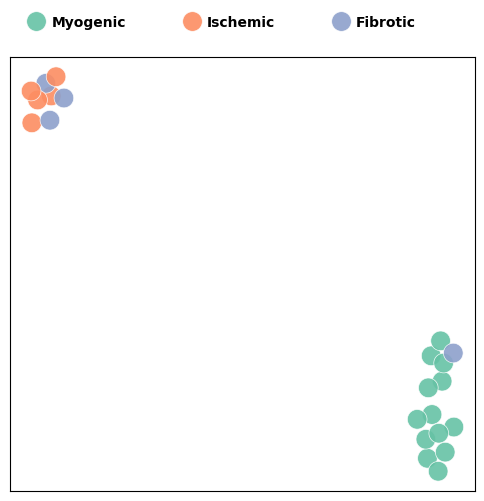

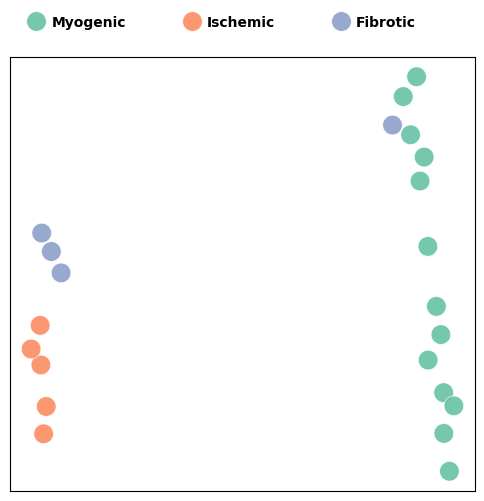

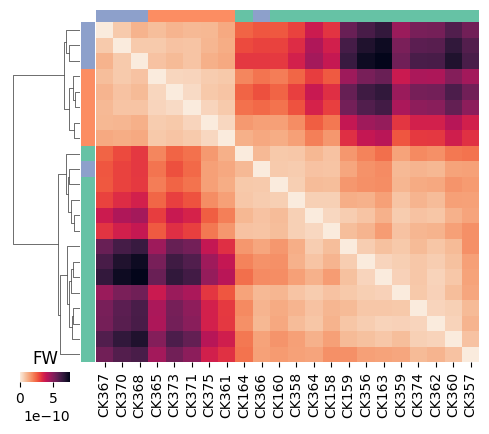

Role2vec-FGW


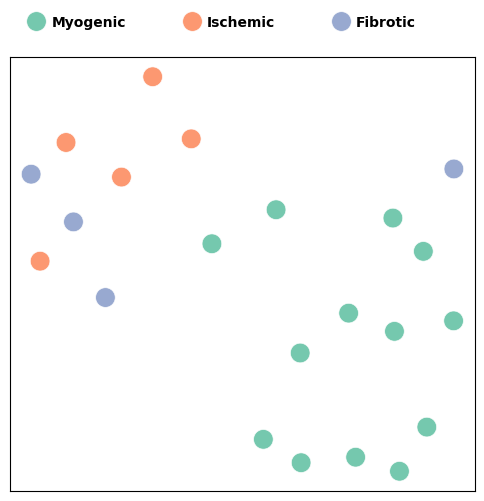

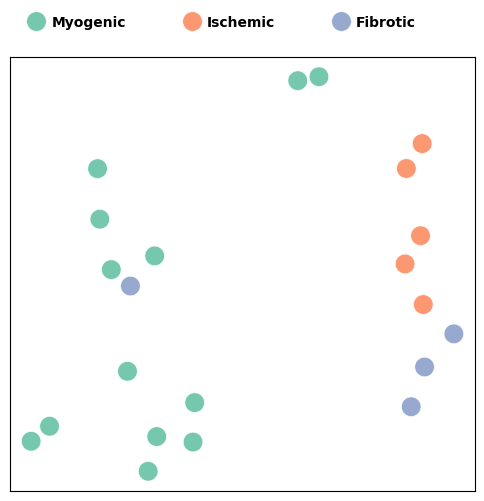

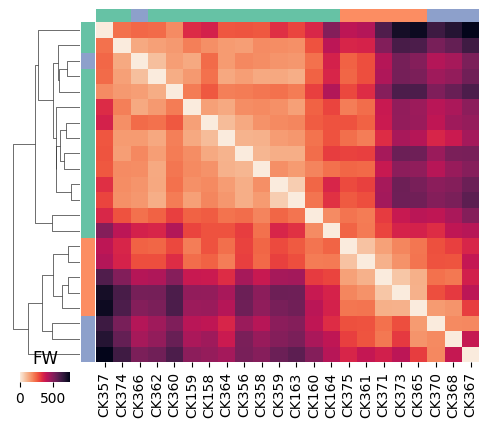

Node2Vec-FGW


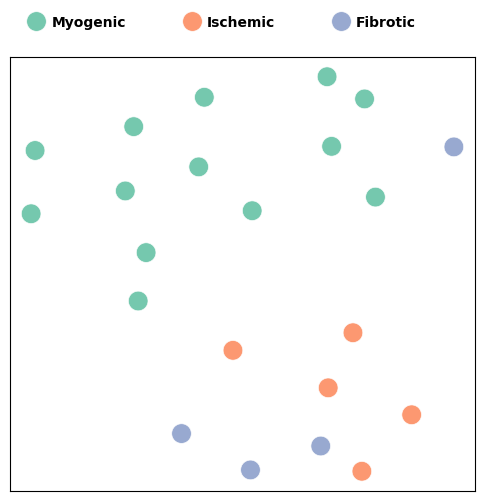

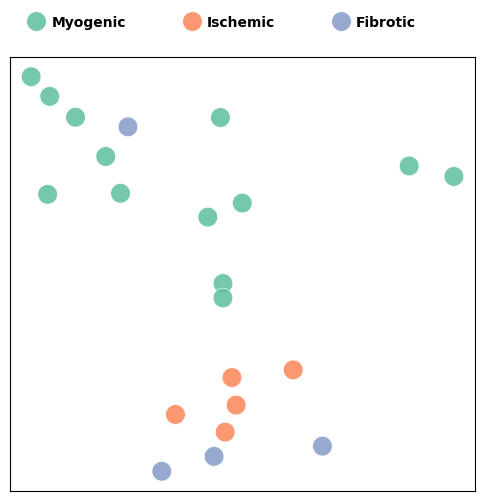

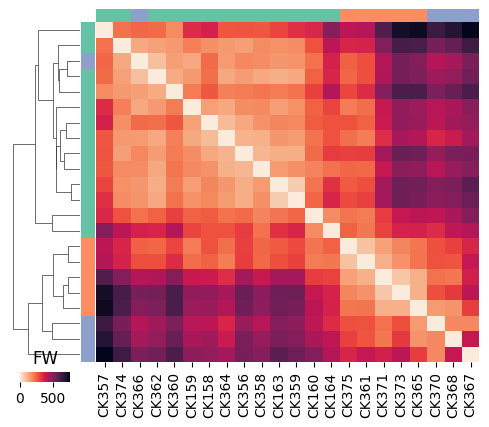

CNP


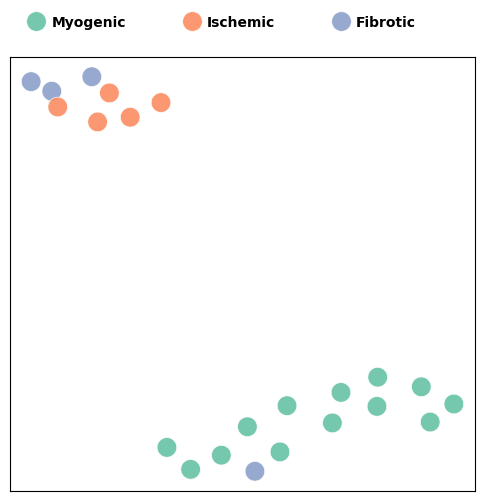

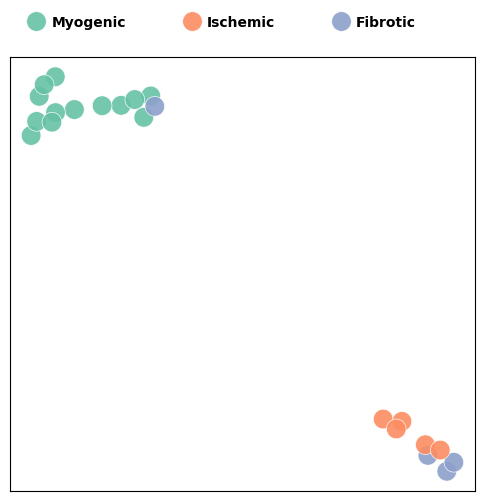

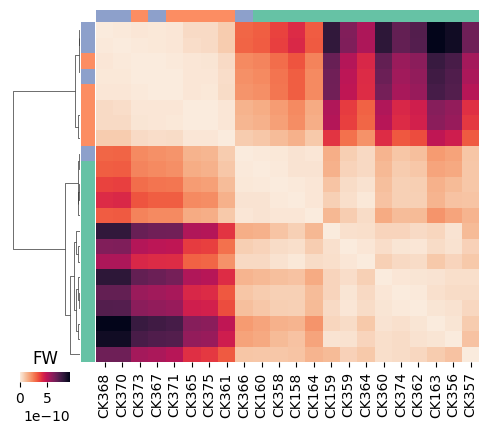

CCB


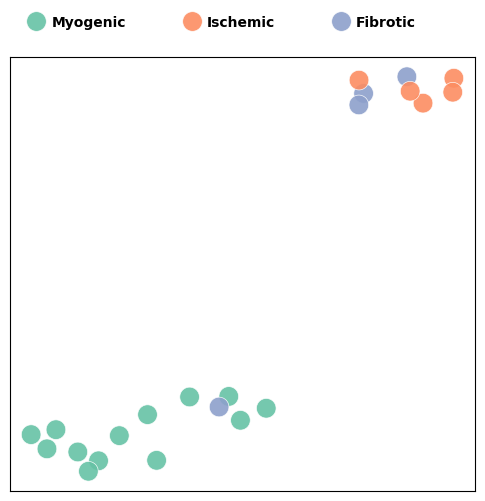

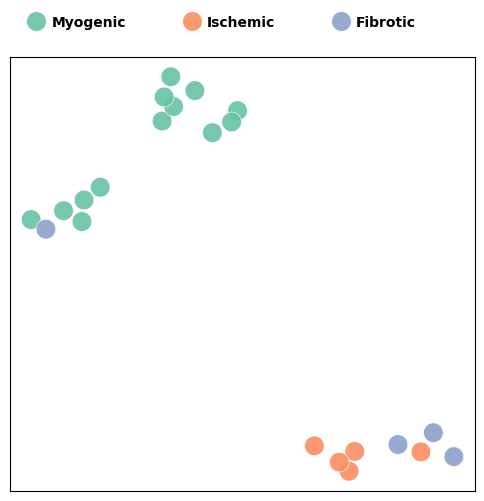

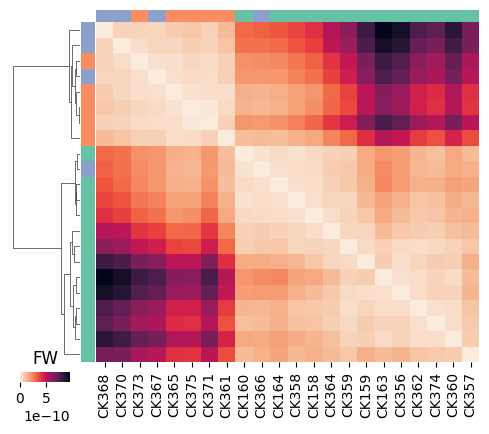

Role2vec-GW


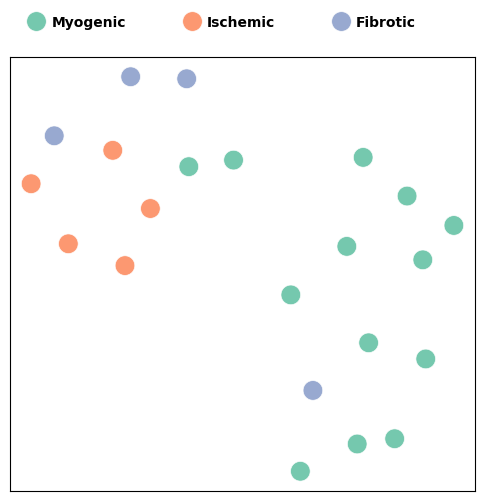

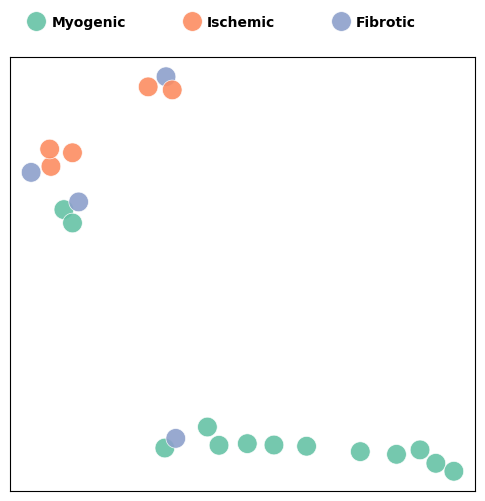

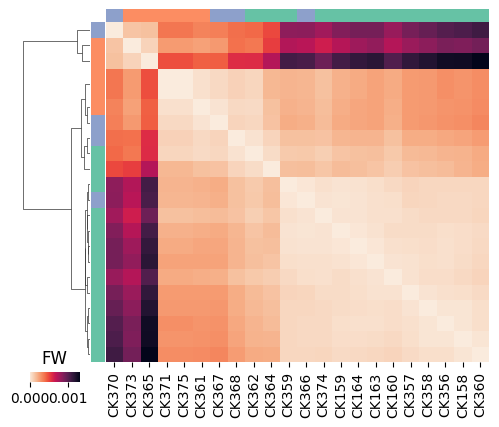

Node2Vec-GW


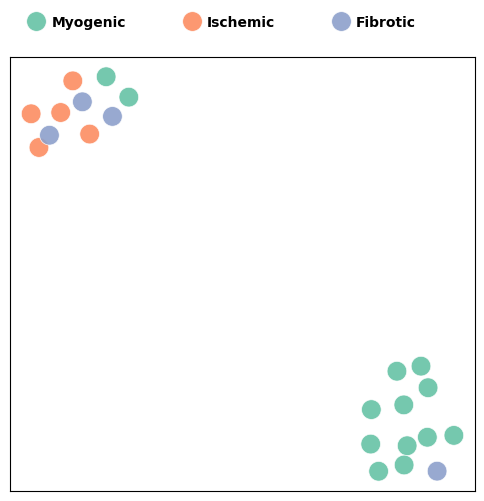

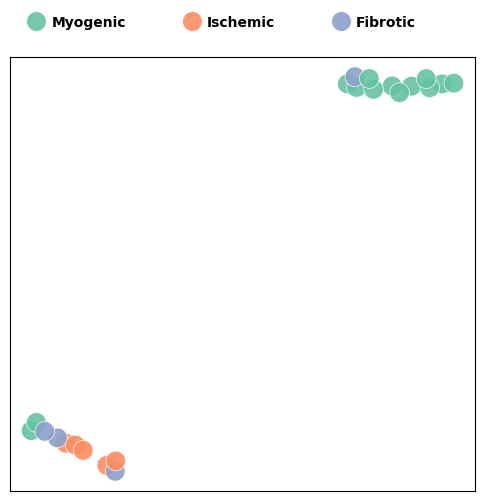

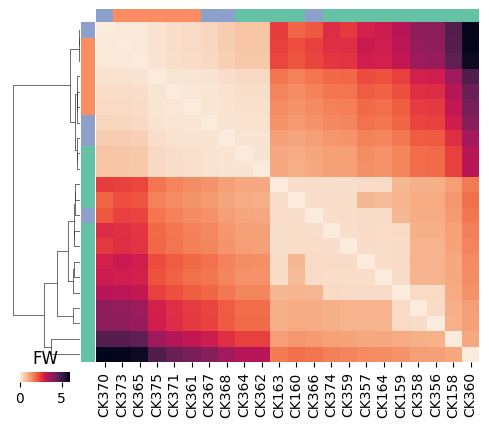

scRNA-Wasserstein


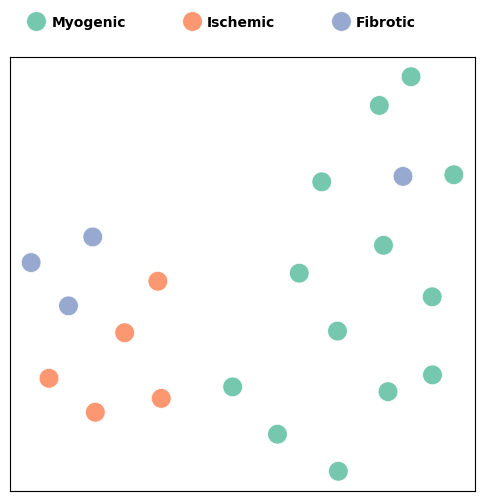

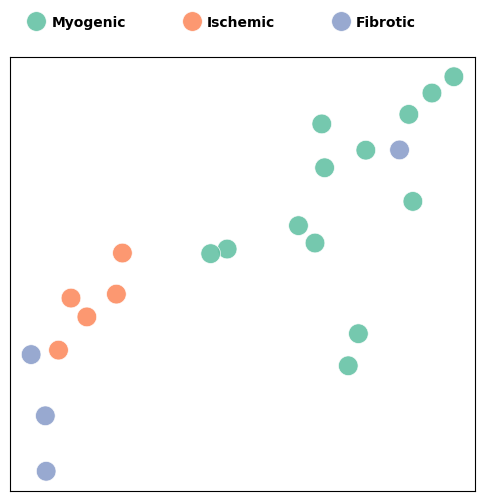

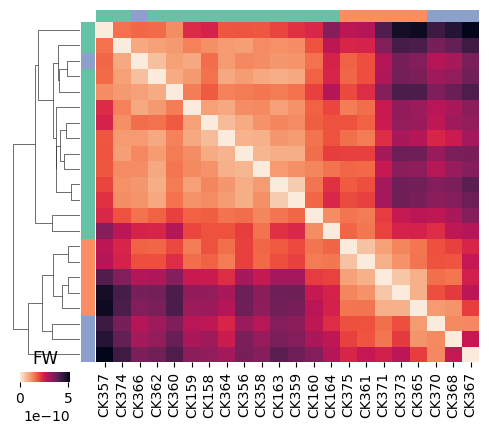

In [10]:
linkage = {}

import time
%load_ext autoreload
%autoreload 2
#Precompute Distances


time_limit = 10
for method, func in methods.items():
    if times.get(method, 0) < time_limit:
        st = time.time()
        precomputed_dists[method], plans[method],struct_cost[method], feat_cost[method] = func(graphs,None,features)
        et = time.time()
        times[method] = et - st
        precomputed_dists[method][precomputed_dists[method]<0] = 0

    #fig, axs = plt.subplots(1,5,figsize=(25,5))
    #plot_heatmap(precomputed_dists[method],patient_ids,ax=axs[0])
    #plot_emb(precomputed_dists[method],method='tsne',colors=labels,ax=axs[1],legend=False,verbose=True,hue_order=label_order,cmap="Set2",annotation=patient_ids)
    #plot_emb(precomputed_dists[method],method='mds',colors=labels,ax=axs[2],legend=False,verbose=True,hue_order=label_order,cmap="Set2",annotation=patient_ids)
    #plot_emb(precomputed_dists[method],method='umap',colors=labels,ax=axs[3],legend=False,verbose=True,hue_order=label_order,cmap="Set2",annotation=patient_ids)
    #plot_emb(precomputed_dists[method],method='diffusion',colors=labels,ax=axs[4],legend=True,verbose=True,hue_order=label_order,cmap="Set2",annotation=patient_ids)
    #fig.suptitle(method)
    print(method)
    plot_emb(precomputed_dists[method],method='umap',colors=labels,legend="Top",title="",verbose=True,hue_order=label_order,cmap="Set2",annotation=None,s=200)
    plot_emb(precomputed_dists[method],method='tsne',colors=labels,legend="Top",title="",verbose=True,hue_order=label_order,cmap="Set2",annotation=None,s=200)

    linkage[method]=hier_clustering(precomputed_dists[method],labels, ax=None,hue_order=label_order,cmap="Set2",annotation=patient_ids,dist_name="FW")
    plt.show()


In [ ]:
path = "/home/kuehn/G4P_clean/2024-fused-wasserstein-multimodal-graph-optimal-transport-based-on-probabilistic-node-embeddings-with-application-in-genomics-and-transcriptomics/data/results/"
#" #+datetime.now().strftime("%H:%M:%S")
save_name = "myocard_graphs_maybefinal" 

precomputed_dists_old = precomputed_dists
precomputed_dists = {key: precomputed_dists_old[key] for key in methods.keys()}

times_old = times
times = {key: times_old [key] for key in methods.keys()}


def tri_to_flat(tri_matrix):
    n = tri_matrix.shape[0]
    list = tri_matrix[np.triu_indices(n)].flatten()
    return list
    

def flat_to_tri(list):
    n = int(0.5 * (np.sqrt(8 * len(list) + 1) -1)) #Solves len(flat)= N(N+1)/2 for N
    tri_matrix = np.zeros((n,n))
    ind = np.triu_indices(n)
    tri_matrix[ind] = np.array(list)
    return tri_matrix


if False:
    method_name = f"CCB-TiedW_a0.5"
    np.savez(path+name+"graph_dists.npz",precomputed_dists[method_name])
    np.savez_compressed(path+name+"transport_plans.npz",tri_to_flat(plans[method_name])) 
    np.savez_compressed(path+name+"struct_cost.npz",tri_to_flat(struct_cost[method_name])) 
    np.savez_compressed(path+name+"feat_cost.npz",tri_to_flat(feat_cost[method_name]))

save=True
if save:
    if True: #input(f"Currently saving is set to {save}, please confirm that you want to overwrite disk") =='':
        np.save(path+save_name+"dists.npy",precomputed_dists)
        np.save(path+save_name+"times.npy",times) 
        np.save(path+save_name+"labels.npy",labels)
        np.save(path+save_name+"patientid.npy",patient_ids)

    # = np.load(path+name+"dists.npy",allow_pickle=True).tolist()
    #times = np.load(path+name+"times.npy",allow_pickle=True).tolist()

print(f"Saved under {path+save_name}dists.npy")

Saved under /home/kuehn/G4P_clean/2024-fused-wasserstein-multimodal-graph-optimal-transport-based-on-probabilistic-node-embeddings-with-application-in-genomics-and-transcriptomics/data/results/myocard_graphs_maybefinaldists.npy


In [10]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier


def KNN_from_dists(Graphs, labels, precomputed_dists=None, n_splits=20, method="TiedOT",n_neighbors=3,weights=None,test_size=0.1):
    predicted_labels, true_labels, scores, ari = [],[],[],[]


    if n_splits>0:
        sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size,random_state=0)
        train_test_inds = sss.split(np.zeros(len(Graphs)), labels)
    else:
        #Train = Test
        train_test_inds = [(np.arange(len(Graphs)),np.arange(len(Graphs)))]  #, np.arange(len(Graphs)))

    for i, (train_index, test_index) in enumerate(train_test_inds):
        if precomputed_dists is None:
            train_dists = compute_dists([Graphs[t] for t in train_index],None,method=method)
            test_to_train_dists = compute_dists([Graphs[t] for t in test_index],[Graphs[t] for t in train_index],method=method)
        else:
            train_dists = get_dist_precomputed(precomputed_dists, train_index, train_index)
            test_to_train_dists = get_dist_precomputed(precomputed_dists, test_index, train_index)

        
        neigh = KNeighborsClassifier(n_neighbors=n_neighbors, metric="precomputed",weights=weights)
        neigh.fit(train_dists,[labels[t] for t in train_index])

        predicted_labels.append(neigh.predict(test_to_train_dists))
        true_labels.append(np.asarray([labels[t] for t in test_index]))
        scores.append(neigh.score(test_to_train_dists,true_labels[-1]))
        ari.append(adjusted_rand_score(predicted_labels[-1],true_labels[-1]))


    return predicted_labels, true_labels, scores, ari


def compute_dists(Graphs,Graphs2=None, method="TiedOT"):
    dist, plan = methods[method](Graphs,Graphs2)
    dist[dist<0] = 0
    return dist

def get_dist_precomputed(precomputed_dists, ind1, ind2):
    return precomputed_dists[ind1,:][:,ind2]

def plot_1split(predicted, true,title=None,ax=None):
    annot_labels_ind =np.unique(true,return_index=True)[1]
    annot_labels = true[annot_labels_ind]
    #ind
    cf_matrix = confusion_matrix(true, predicted, labels=annot_labels)
    if ax is None:
        plt.figure()
    ax = sns.heatmap(cf_matrix, annot=True, #fmt='.0', 
            cmap='Blues', xticklabels=annot_labels,yticklabels=annot_labels,ax=ax,fmt='g')
    ax.set(xlabel="Predicted Label", ylabel="True Label")
    ax.set_title(title)

def plot_table(df,tranpose=False):
    format_df = df
    format_df.set_index('method',inplace=True)
    if tranpose:
        format_df = format_df.transpose()
    display(format_df)
    print(format_df.to_latex(index=True,
                  #formatters={"name": str.upper},
                  float_format="{:.2f}".format,
    ))
    

def np_unique_indices(arr, **kwargs):
    """Unique indices for N-D arrays."""
    arr = np.asarray(arr)
    vals, indices, *others = np_unique_indices_1d(arr.reshape(-1), **kwargs)
    indices = [list(np.stack(np.unravel_index(x, arr.shape))) for x in indices]

    indices = [list(i[0]) for i in indices]
    return vals, indices, *others


def np_unique_indices_1d(arr, **kwargs):
    """Unique indices for 1D arrays."""
    sort_indices = np.argsort(arr)
    arr = np.asarray(arr)[sort_indices]
    vals, first_indices, *others = np.unique(
        arr, return_index=True, **kwargs
    )
    indices = np.split(sort_indices, first_indices[1:])
    for x in indices:
        x.sort()
    return vals, list(indices), *others

231.0
FusedWasserstein
vals
9.600149350335794e-11
1.2571624149249253e-10
1.570133270445812e-10


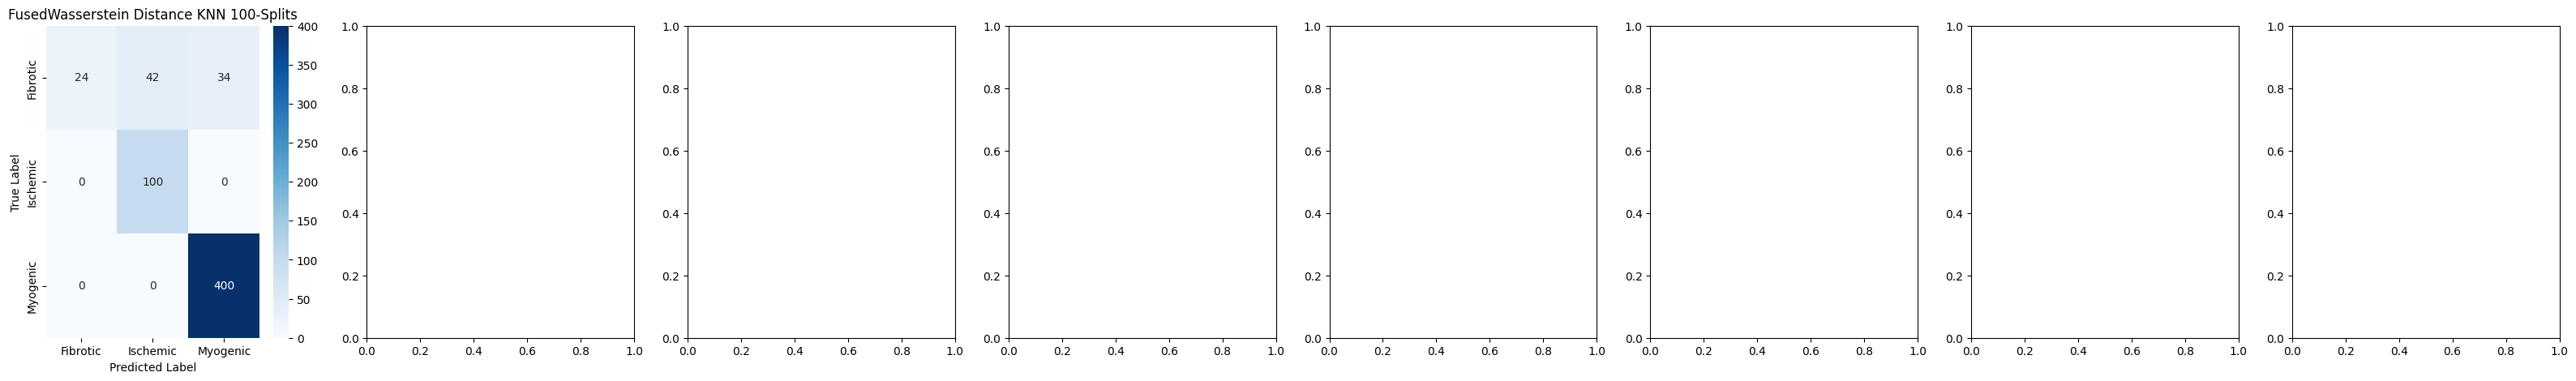

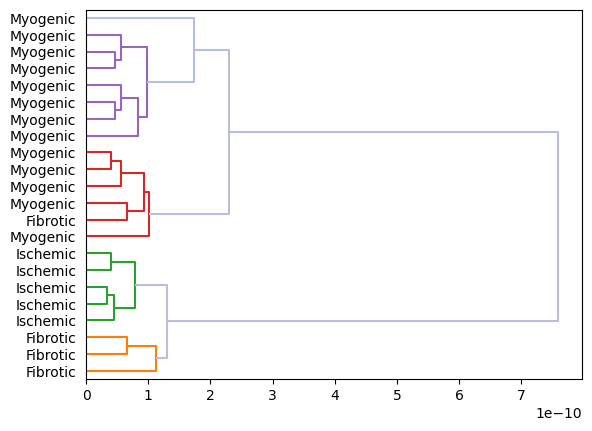

[[14, 15, 16, 17], [10, 13, 18, 19, 21], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 20]]
[[15, 16, 17], [10, 13, 18, 19, 21], [0, 2, 4, 7, 12, 14], [1, 3, 5, 8, 9, 11, 20], [6]]
MatchingResult(score=1.090447201578219, std=None)
231.0
Role2vec-FGW
vals
122.06985944107736
159.85338736331556
274.7746518444328


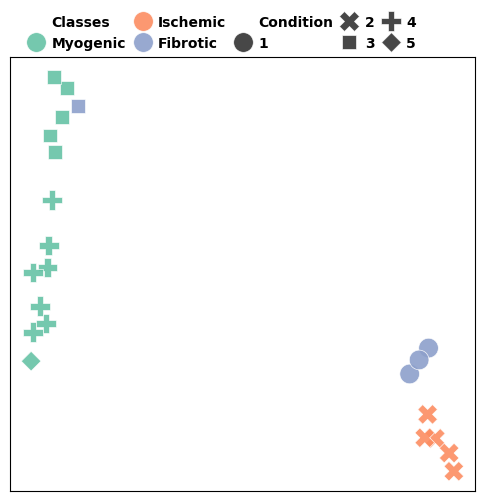

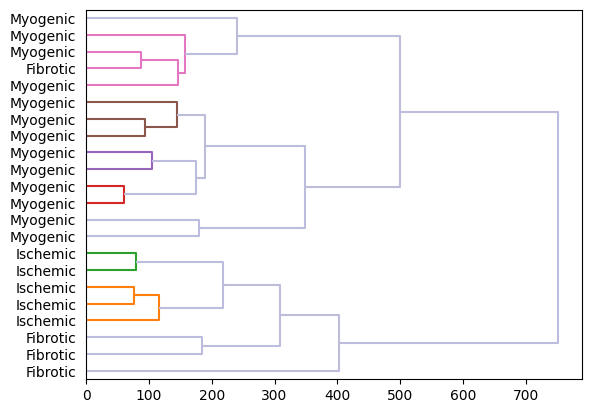

[[14, 15, 16, 17], [10, 13, 18, 19, 21], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 20]]
[[16], [17], [13, 18, 19], [10, 21], [15], [4], [2], [3, 8], [5, 7], [0, 1, 12], [9, 11, 14, 20], [6]]
MatchingResult(score=2.30435485461896, std=None)
231.0
Node2Vec-FGW
vals
122.37674549021918
160.25526195147748
275.1924967467555


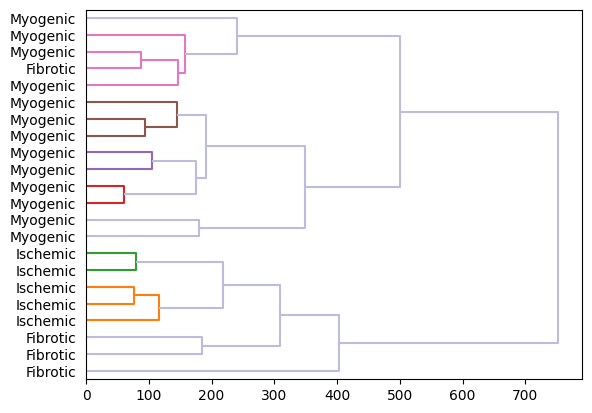

[[14, 15, 16, 17], [10, 13, 18, 19, 21], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 20]]
[[16], [17], [13, 18, 19], [10, 21], [15], [4], [2], [3, 8], [5, 7], [0, 1, 12], [9, 11, 14, 20], [6]]
MatchingResult(score=2.30435485461896, std=None)
231.0
CNP
vals
9.530768119683885e-11
1.2480767775776517e-10
1.2627328333720766e-10


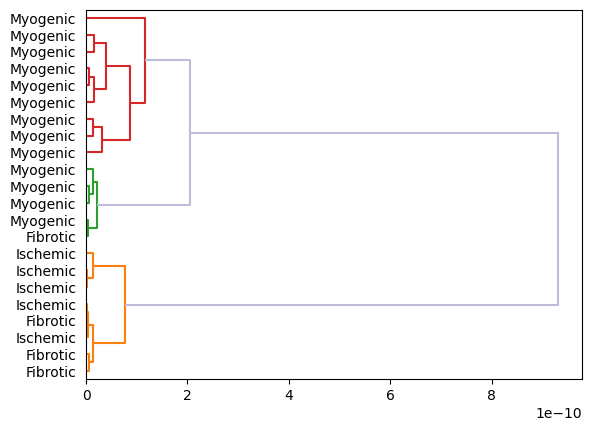

[[14, 15, 16, 17], [10, 13, 18, 19, 21], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 20]]
[[10, 13, 15, 16, 17, 18, 19, 21], [0, 2, 4, 7, 14], [1, 3, 5, 6, 8, 9, 11, 12, 20]]
MatchingResult(score=1.1848461962966568, std=None)
231.0
CCB
vals
9.934404731748632e-11
1.3009339529670825e-10
1.4470679376820012e-10


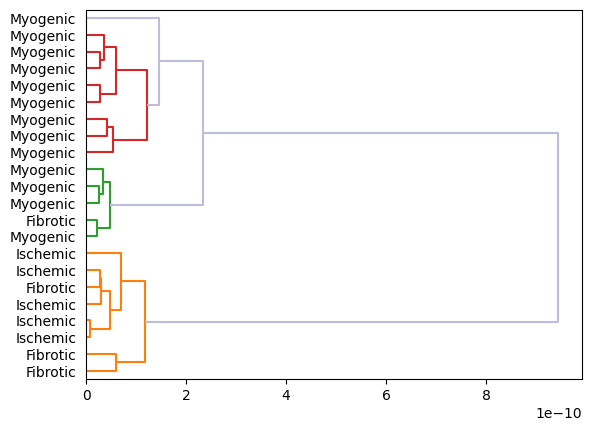

[[14, 15, 16, 17], [10, 13, 18, 19, 21], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 20]]
[[10, 13, 15, 16, 17, 18, 19, 21], [0, 2, 4, 7, 14], [1, 3, 5, 8, 9, 11, 12, 20], [6]]
MatchingResult(score=1.3907246059776026, std=None)
231.0
Role2vec-GW
vals
0.00010710089325430521
0.00014025116973778064
0.00015697701959996663


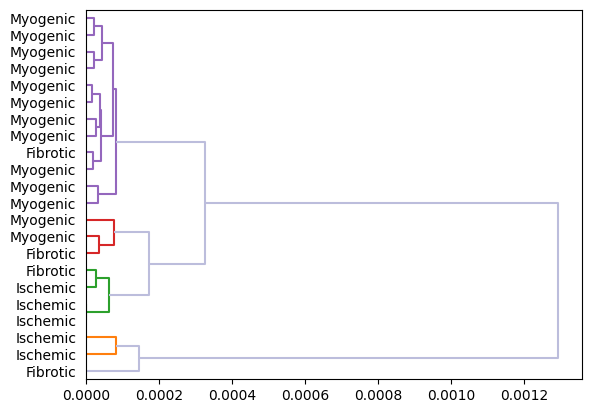

[[14, 15, 16, 17], [10, 13, 18, 19, 21], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 20]]
[[13, 19], [17], [10, 15, 18, 21], [11, 12, 16], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 14, 20]]
MatchingResult(score=1.4487510775791308, std=None)
231.0
Node2Vec-GW
vals
0.5664398609032424
0.7417664845161506
1.1678990939469278


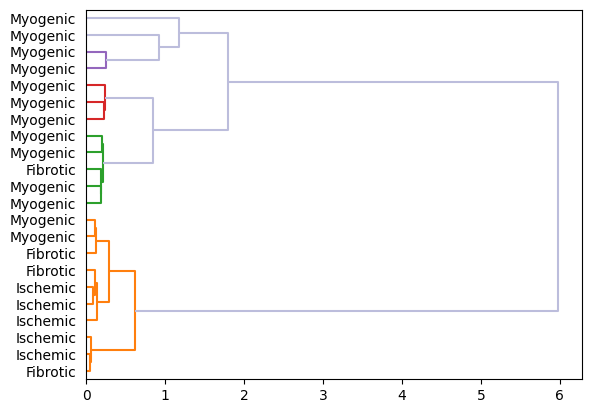

[[14, 15, 16, 17], [10, 13, 18, 19, 21], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 20]]
[[10, 11, 12, 13, 15, 16, 17, 18, 19, 21], [2, 3, 8, 14, 20], [1, 4, 6], [5, 7], [0], [9]]
MatchingResult(score=2.4118333990098826, std=None)
231.0
scRNA-Wasserstein
vals
8.478384139331498e-11
1.1102645896743629e-10
1.9097355234347917e-10


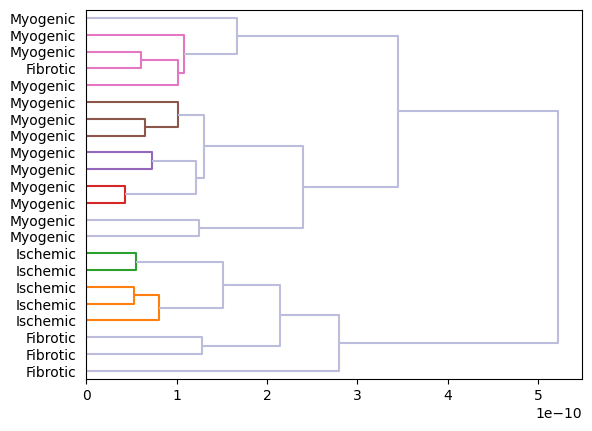

[[14, 15, 16, 17], [10, 13, 18, 19, 21], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 20]]
[[16], [17], [13, 18, 19], [10, 21], [15], [4], [2], [3, 8], [5, 7], [0, 1, 12], [9, 11, 14, 20], [6]]
MatchingResult(score=2.30435485461896, std=None)


ARI    VarInf    Time
method                                    
FusedWasserstein    0.47  1.090447    1.64
Role2vec-FGW        0.12  2.304355    7.52
Node2Vec-FGW        0.12  2.304355   15.94
CNP                 0.46  1.184846    1.69
CCB                 0.38  1.390725    1.72
Role2vec-GW         0.54  1.448751   11.69
Node2Vec-GW        -0.00  2.411833   26.52
scRNA-Wasserstein   0.12  2.304355    2.68

\begin{tabular}{llrl}
\toprule
 & ARI & VarInf & Time \\
method &  &  &  \\
\midrule
FusedWasserstein & 0.47 & 1.09 &  1.64 \\
Role2vec-FGW & 0.12 & 2.30 &  7.52 \\
Node2Vec-FGW & 0.12 & 2.30 &  15.94 \\
CNP & 0.46 & 1.18 &  1.69 \\
CCB & 0.38 & 1.39 &  1.72 \\
Role2vec-GW & 0.54 & 1.45 &  11.69 \\
Node2Vec-GW & -0.00 & 2.41 &  26.52 \\
scRNA-Wasserstein & 0.12 & 2.30 &  2.68 \\
\bottomrule
\end{tabular}



In [16]:
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import adjusted_rand_score
import sklearn
import scipy as sp

import cdlib
from cdlib import NodeClustering
from scipy.cluster import hierarchy

# Weighted
#KNN over precomputed distances
fig, axs = plt.subplots(1,len(methods.keys()),figsize=(len(methods.keys())*5,5),squeeze=False)



results = {"method":[],
           #"KNN T=0.75":[],
           "ARI":[],
           "VarInf":[],
           #"KNN T=0.1":[],
           #"SC":[],
           
           "Time":[]}

#for m, (method, dist) in enumerate(precomputed_dists.items()):
for m, (method, func) in enumerate(methods.items()):
    dist = precomputed_dists[method]
    pred, true, score, ari = KNN_from_dists(graphs,labels,method=method,precomputed_dists=precomputed_dists[method],weights='distance',test_size=0.25,n_splits=100)
    #for i,(p,t) in enumerate(zip(pred,true)):
    plot_1split(np.concatenate(pred),np.concatenate(true),title=f"{method} Distance KNN {len(pred)}-Splits",ax=axs[0,m])

    #pred2, true2, score2, ari = KNN_from_dists(graphs,labels,method=method,precomputed_dists=precomputed_dists[method],weights='distance',test_size=0.9)
    #for i,(p,t) in enumerate(zip(pred,true)):
    #plot_1split(np.concatenate(pred2),np.concatenate(true2),title=f"{method} Distance KNN {len(pred2)}-Splits",ax=axs[1,m])

    zero_dia_dists = precomputed_dists[method]
    np.fill_diagonal(zero_dia_dists,0)
    sil = silhouette_score(zero_dia_dists,labels,metric="precomputed")

    #ari = adjusted_rand_score(np.concatenate(true),np.concatenate(pred))
    
    #np.quantile(dist,q=0.2)
    
    #pred_cluster = sklearn.cluster.AgglomerativeClustering(metric='precomputed',linkage='single',n_clusters=None,distance_threshold=thresh).fit_predict(precomputed_dists[method])
    #ari = sklearn.metrics.adjusted_rand_score(labels,pred_cluster)

    non_dia_n = (len(dist)*(len(dist)-1)/2)
    non_zero = dist.flatten()
    non_zero = non_zero[non_zero!=0]
    thresh = 0.5*np.mean(non_zero) #np.quantile(dist,0.5)
    print(non_dia_n)
    print(method)
    print("vals")
    print(np.mean(dist)*0.4)
    print(thresh)
    print(np.median(dist))

    link = sp.cluster.hierarchy.linkage(sp.spatial.distance.squareform(dist), method='complete', optimal_ordering=True)
    #print(link)
    plt.figure()

    hierarchy.dendrogram(link, ax=None, color_threshold=thresh,
                           above_threshold_color='#bcbddc',
                           orientation='right',labels=patient_ids)
    plt.show()
    
   
    pred_cluster = sp.cluster.hierarchy.fcluster(link,t=thresh,criterion="distance")
    #pred_cluster = sp.cluster.hierarchy.fcluster(link,t=100000*np.amax(dist),criterion="")
    if "FusedWasserstein" in method:
        plot_emb(precomputed_dists[method],method='tsne',colors=labels,symbols=pred_cluster,legend="Top",title="",verbose=True,hue_order=label_order,cmap="Set2",annotation=None,s=200)
        file_name = method+"_tsne"
        plt.savefig("/home/kuehn/G4P_clean/2024-fused-wasserstein-multimodal-graph-optimal-transport-based-on-probabilistic-node-embeddings-with-application-in-genomics-and-transcriptomics/plots/"+file_name+".pdf")
    ari = sklearn.metrics.adjusted_rand_score(labels,pred_cluster)


    _ , grouped_labels = np_unique_indices(labels) #[np.where([labels==l]) for l in np.unique(labels)]
    _ , grouped_clust = np_unique_indices(pred_cluster) #[np.where([pred_cluster==l]) for l in np.unique(pred_cluster)]
    print(grouped_labels)
    print(grouped_clust)
    truth = NodeClustering(grouped_labels, graph=None, method_name="Pathological labels")
    pred = NodeClustering(grouped_clust, graph=None, method_name="Predicted Cluster")
    eval = cdlib.evaluation.variation_of_information(truth,pred)
    print(eval)
    #plt.show()
    results["method"].append(method)
    #results["Classification Score"].append(np.average(score))
    #results["KNN T=0.75"].append(f"{np.average(score):.2f}±{np.std(score):.2f}")
    results["VarInf"].append(eval[0])
    #results["KNN T=0.1"].append(f"{np.average(score2):.2f}±{np.std(score2):.2f}")
    results["ARI"].append(f"{ari:.2f}")
    #results["SC"].append(("%.3f" % sil).replace("-0","-").lstrip("0")) 
    results["Time"].append(f"{times[method]/(len(graphs)*(len(graphs)-1)/2) : .2f}")

fig.tight_layout()
plot_table(pd.DataFrame(results))






The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
['myogenic', 'myogenic', 'myogenic', 'myogenic', 'fibrotic', 'myogenic', 'myogenic', 'myogenic', 'myogenic', 'myogenic', 'myogenic', 'myogenic', 'myogenic', 'myogenic', 'ischemic', 'ischemic', 'ischemic', 'ischemic', 'ischemic', 'fibrotic', 'fibrotic', 'fibrotic']
Fib2_Myofib
/home/kuehn/G4P_clean/2024-fused-wasserstein-multimodal-graph-optimal-transport-based-on-probabilistic-node-embeddings-with-application-in-genomics-and-transcriptomics/paper/plots/celltypes_spats//FusedWasserstein_Fib2_Myofib_diffusionmap.pdf


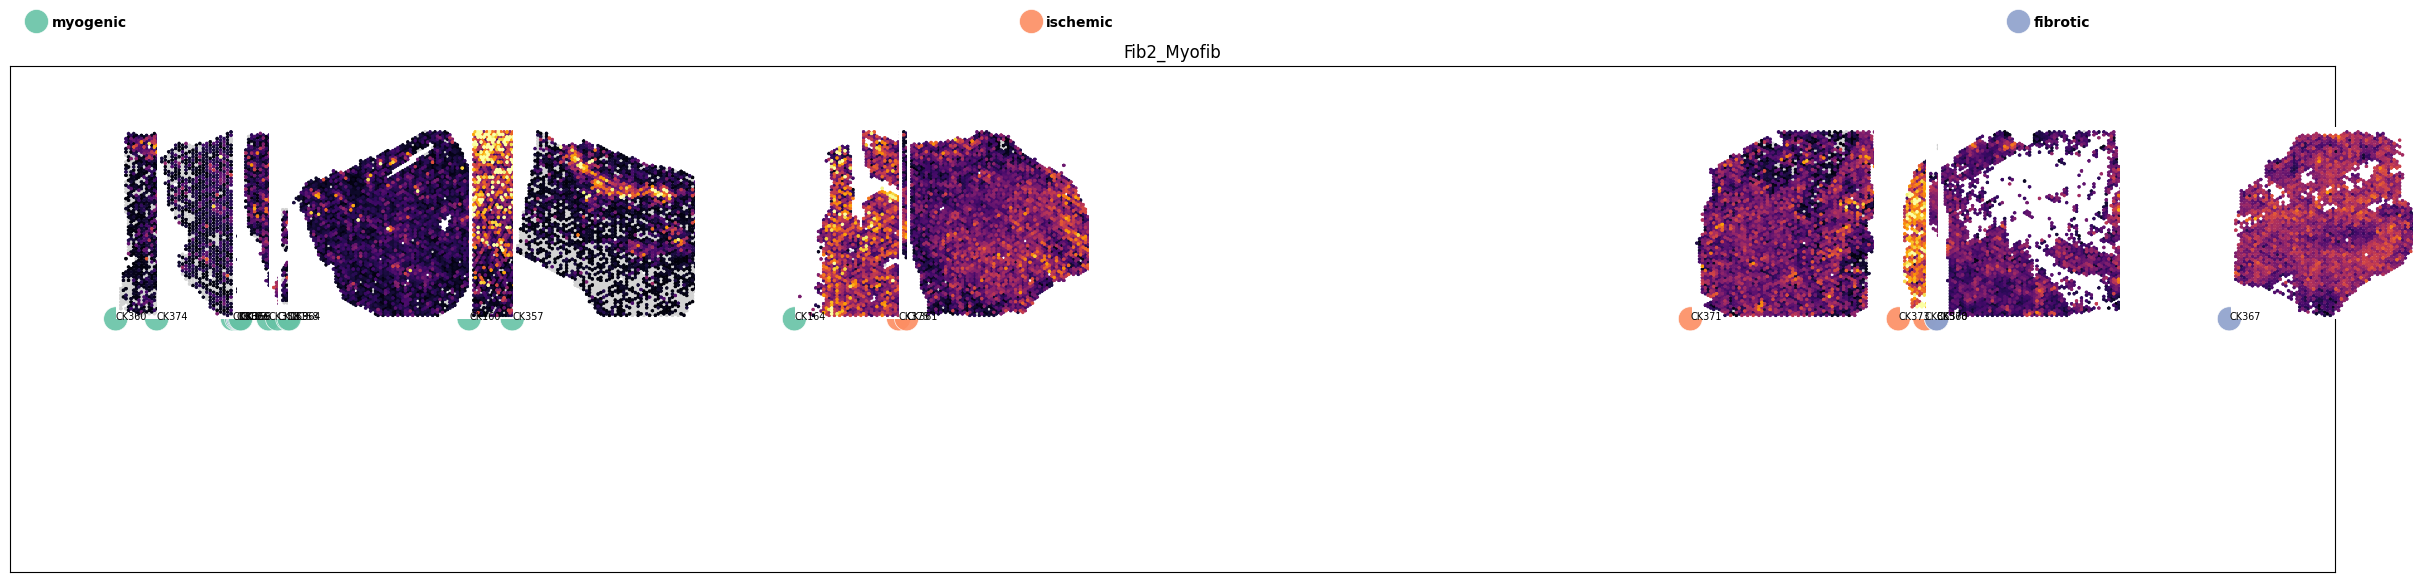

healthy_CM
/home/kuehn/G4P_clean/2024-fused-wasserstein-multimodal-graph-optimal-transport-based-on-probabilistic-node-embeddings-with-application-in-genomics-and-transcriptomics/paper/plots/celltypes_spats//FusedWasserstein_healthy_CM_diffusionmap.pdf


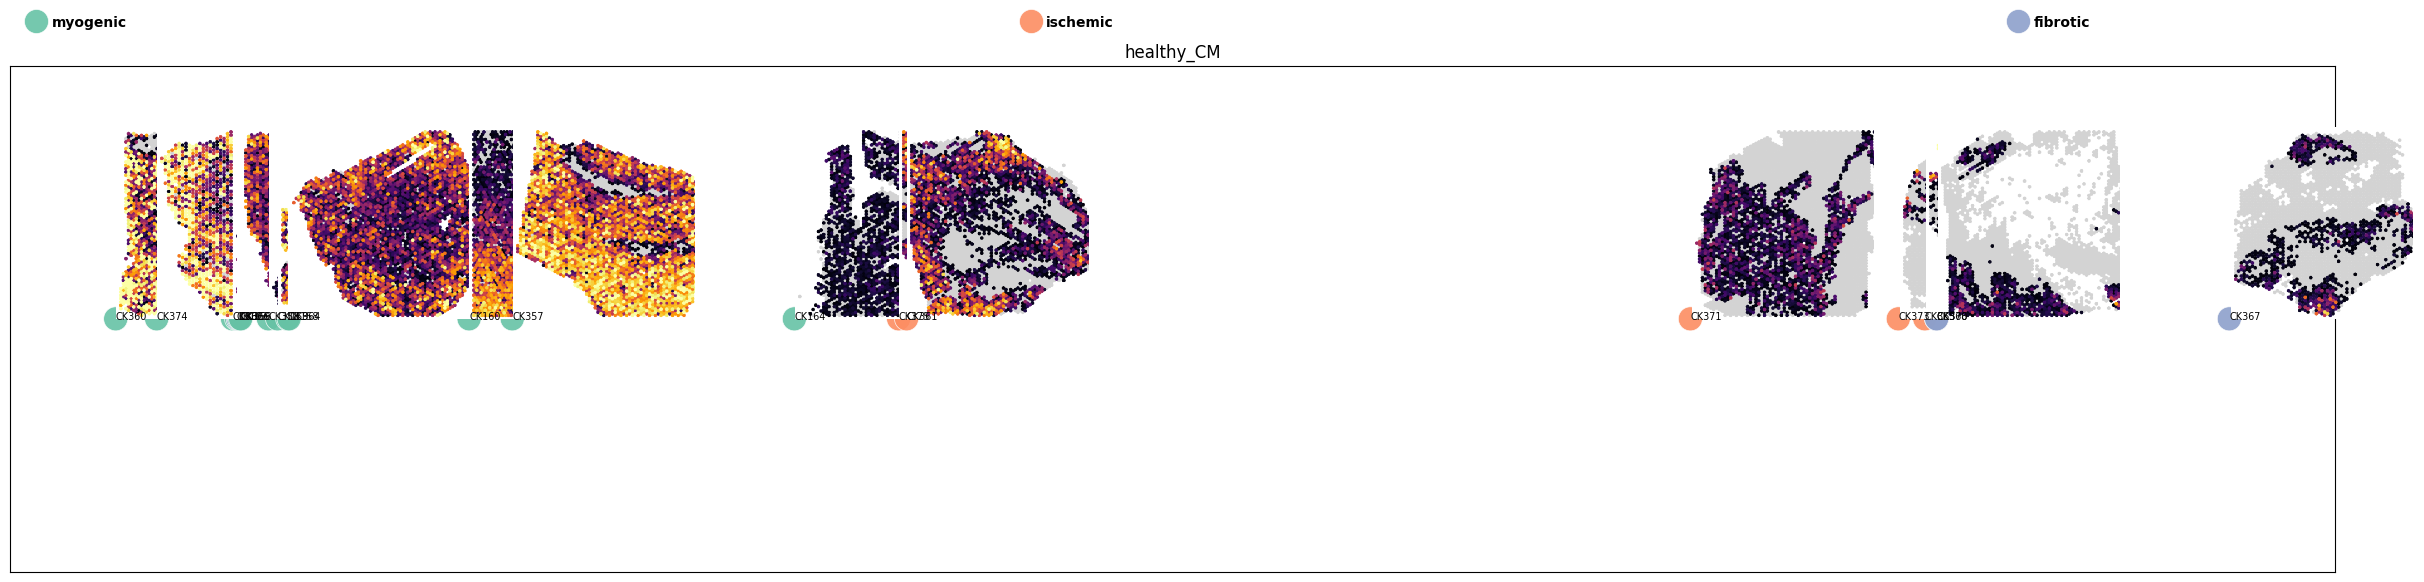

SPP1_Macrophages
/home/kuehn/G4P_clean/2024-fused-wasserstein-multimodal-graph-optimal-transport-based-on-probabilistic-node-embeddings-with-application-in-genomics-and-transcriptomics/paper/plots/celltypes_spats//FusedWasserstein_SPP1_Macrophages_diffusionmap.pdf


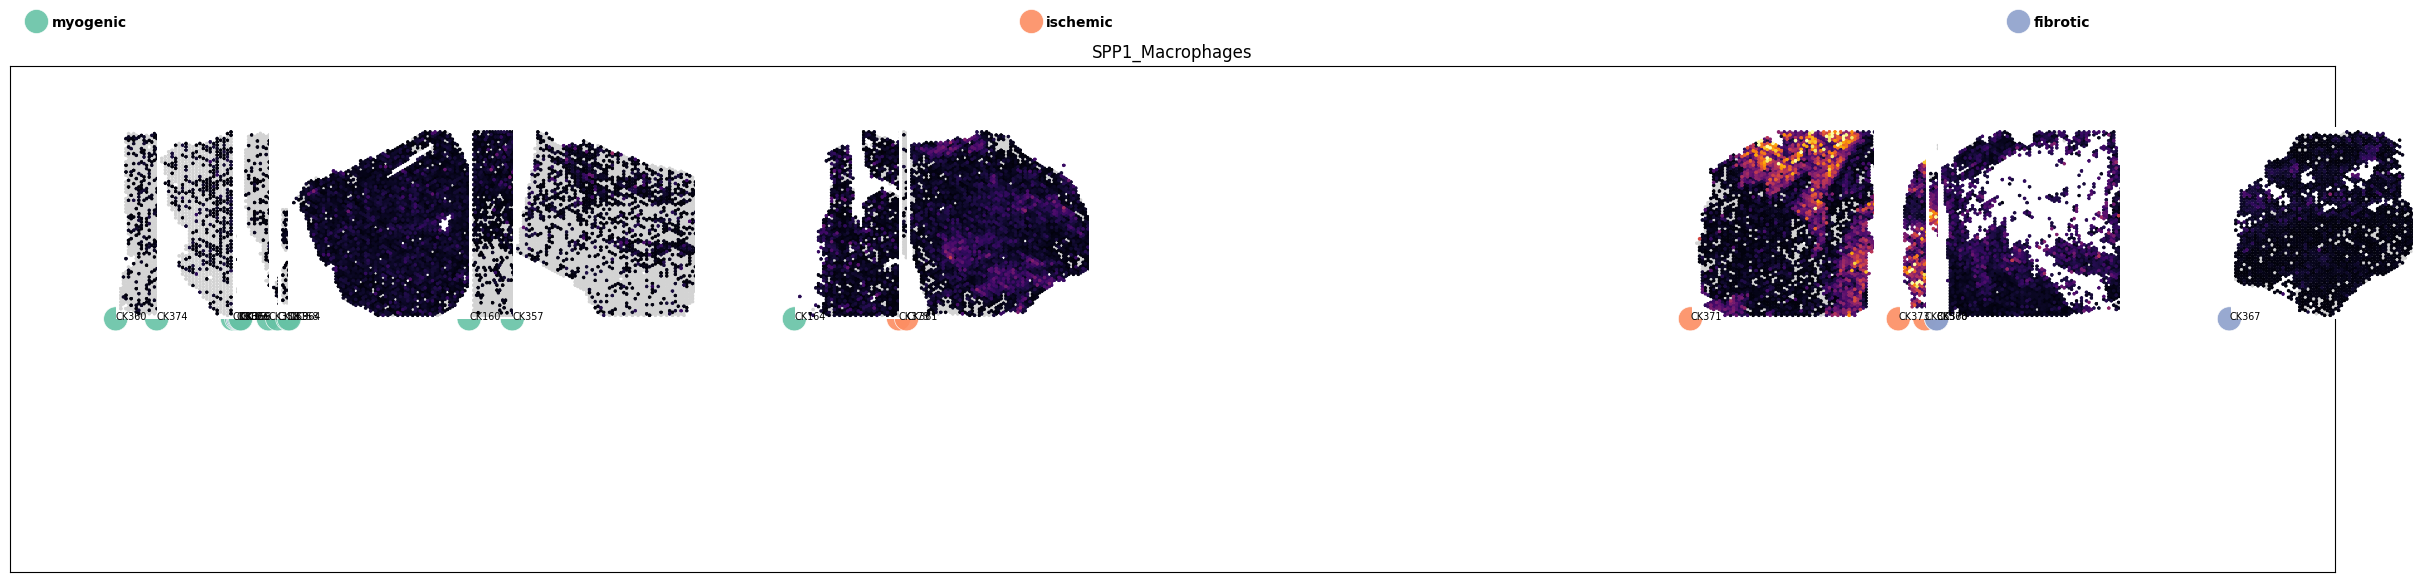

Venous_Endo
/home/kuehn/G4P_clean/2024-fused-wasserstein-multimodal-graph-optimal-transport-based-on-probabilistic-node-embeddings-with-application-in-genomics-and-transcriptomics/paper/plots/celltypes_spats//FusedWasserstein_Venous_Endo_diffusionmap.pdf


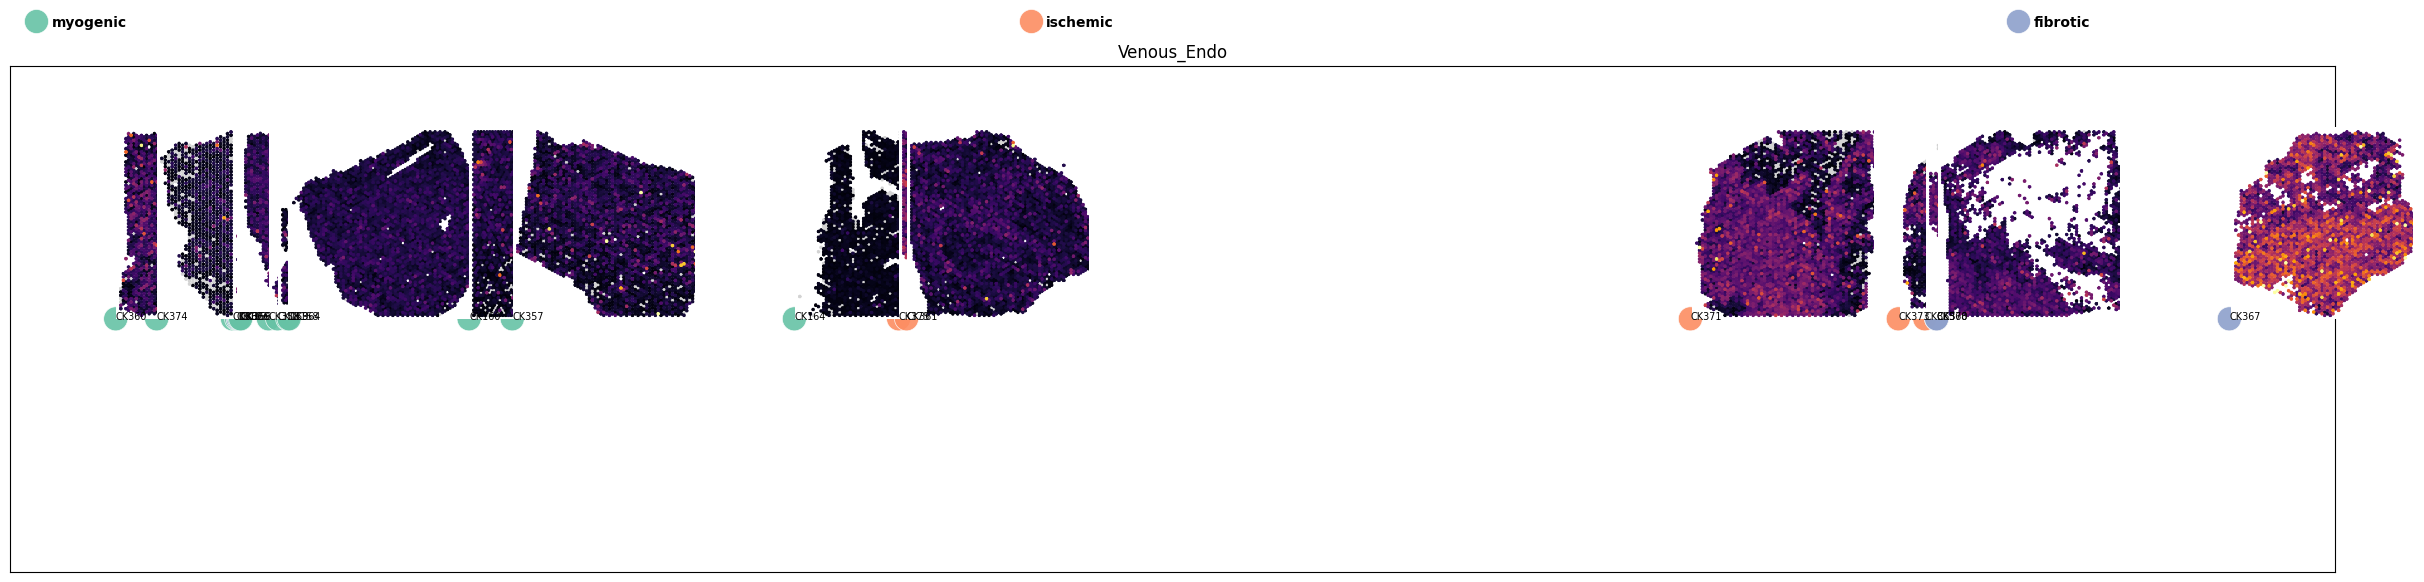

Fib3_C7
/home/kuehn/G4P_clean/2024-fused-wasserstein-multimodal-graph-optimal-transport-based-on-probabilistic-node-embeddings-with-application-in-genomics-and-transcriptomics/paper/plots/celltypes_spats//FusedWasserstein_Fib3_C7_diffusionmap.pdf


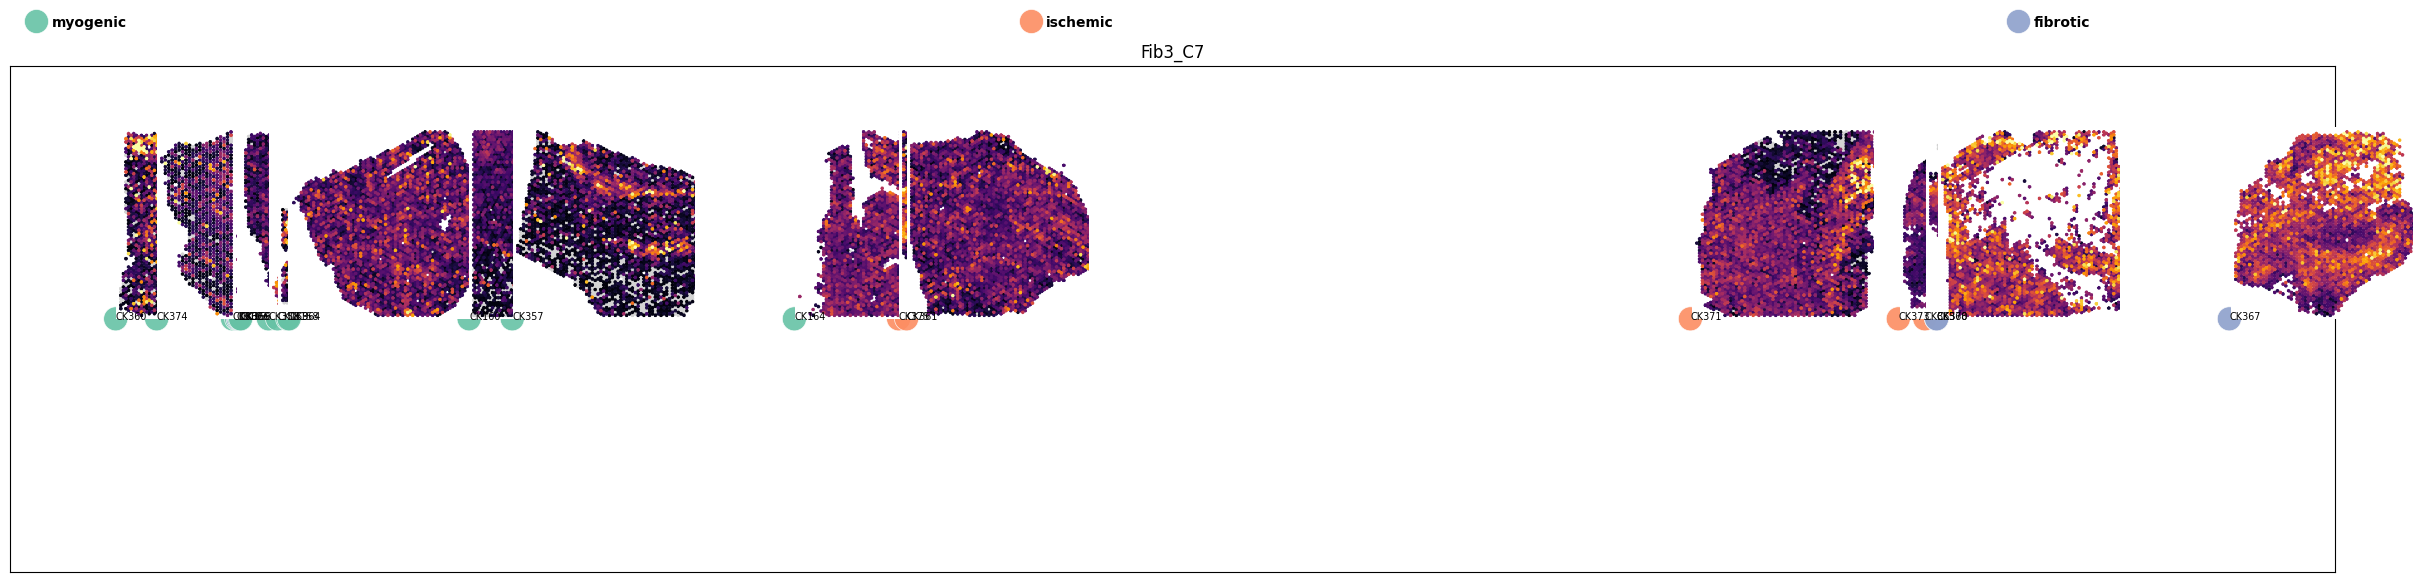

intermediate_CM
/home/kuehn/G4P_clean/2024-fused-wasserstein-multimodal-graph-optimal-transport-based-on-probabilistic-node-embeddings-with-application-in-genomics-and-transcriptomics/paper/plots/celltypes_spats//FusedWasserstein_intermediate_CM_diffusionmap.pdf


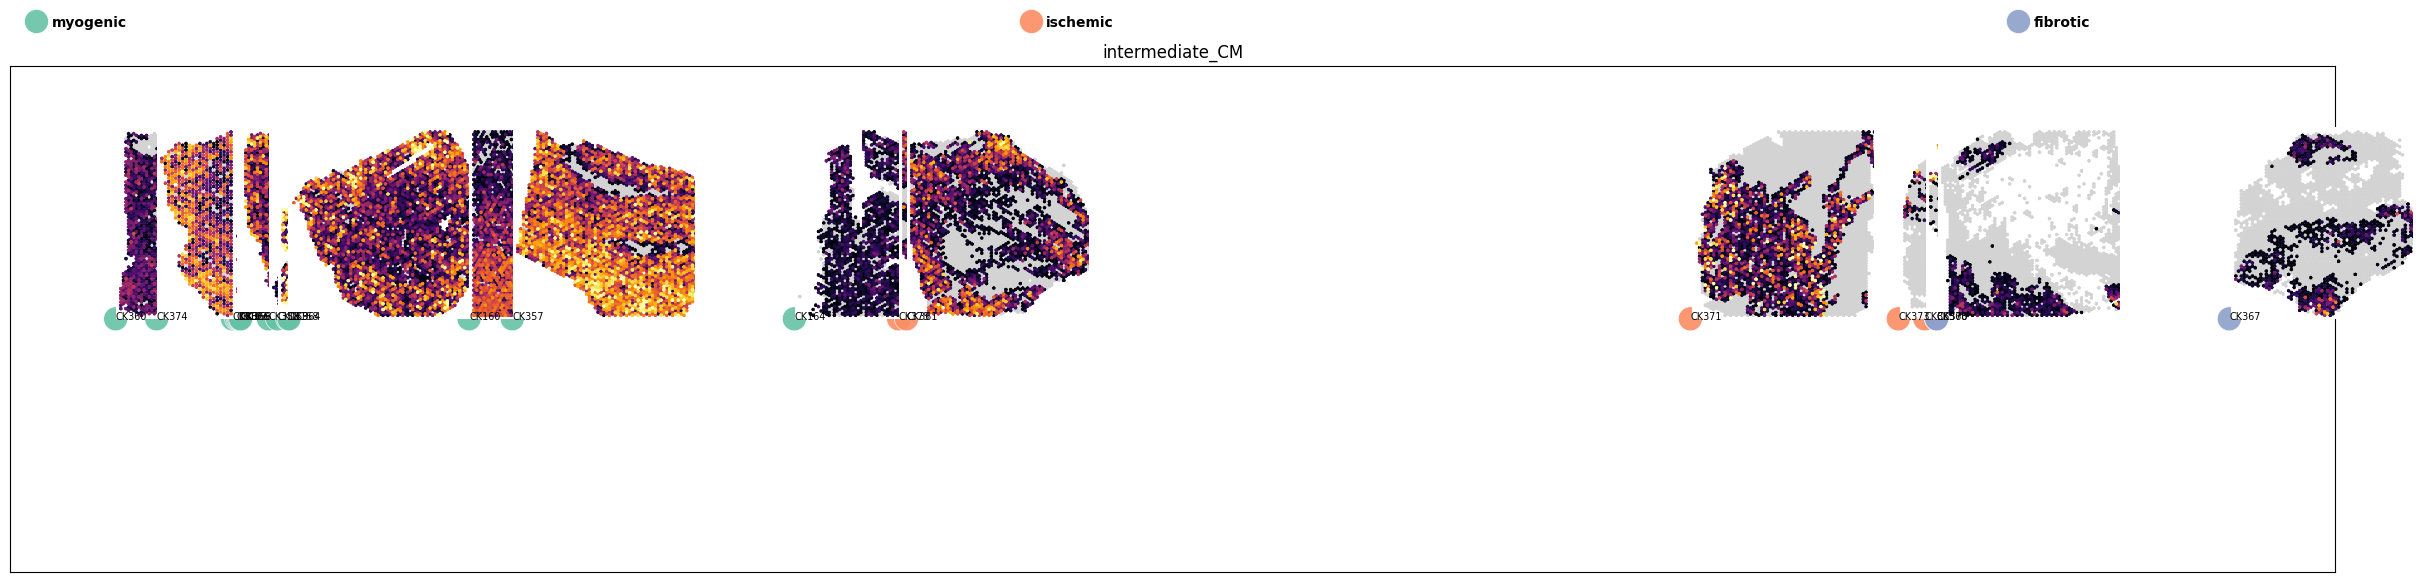

In [ ]:
import os
#new plotting of celltype spatial distributions

%load_ext autoreload
%autoreload 2
save_folder = "/home/kuehn/G4P_clean/2024-fused-wasserstein-multimodal-graph-optimal-transport-based-on-probabilistic-node-embeddings-with-application-in-genomics-and-transcriptomics/paper/plots/celltypes_spats/" 

annotation_image_path = "/home/kuehn/G4P_clean/2024-fused-wasserstein-multimodal-graph-optimal-transport-based-on-probabilistic-node-embeddings-with-application-in-genomics-and-transcriptomics/data/images/celltype_spatial_distribution/23.01 Celltypes/"
considered_celltypes = [f.name for f in os.scandir(annotation_image_path) if f.is_dir()]

#for m, (method, func) in enumerate(methods.items()):
    
    #if True:
#if method == "FW_1/3":
    

#Use wasserstein dist
method="FusedWasserstein"
dist = []
#dist =  precomputed_dists[method] #precomputed_dists[method.replace("/","_")] =
#emb = None
#method = method.replace("/","_")

#use pseudotime from principal graph
df = pd.read_csv("/home/kuehn/G4P/code/notebooks/Results_PILOT/Cell_type_Report/_Samples_Ordered_by_Pseudotime_.csv")
emb = [[x,0] for x in df["pseudotime"]]
labels = list(df["lables"])
label_order = ['myogenic','ischemic','fibrotic']
patient_ids = df["sampleID"]


print(labels)


for c in considered_celltypes:
    print(c)
    celltype_anno_paths = [annotation_image_path+c+f"/ID{id.replace('CK','')}.png" for id in patient_ids] 
    emb = plot_emb(dist,precomputed_emb=emb,s=300,title=c,method='diffusion',colors=labels,symbols=None,ax=None,save_path=f"{save_folder}/{method}_{c}_diffusionmap.pdf",hue_order=label_order,cmap="Set2",annotation=patient_ids, annotation_image_path=celltype_anno_paths ) #,cmap=cmap_dict)
    plt.show()


In [ ]:

%load_ext autoreload
%autoreload 2
save_folder = "/home/kuehn/CNP_OT/cnp-ot/paper/figures/myocardial" 
frames_emb_phate = []
frames_emb_mds = []
frames_dists = []
frames_dists_cluster = []


for m, (method, func) in enumerate(methods.items()):
#if True:
    if "FW" in method:
        
        precomputed_dists[method.replace("/","_")] = precomputed_dists[method]
        method = method.replace("/","_")
    #if "CCB-TiedW_a0.40" in method:
#    method="CCB-TiedW"
  # np-array needed for later indexing

        

    #ordered_dists = np.roll(ordered_dists,-200,axis=(0,1))
        dist = precomputed_dists[method]

    #ordered_dists[:800,:800] = precomputed_dists[method][200:,200:] 
    #ordered_dists[800:,:] = precomputed_dists[method][:200,:] 
    #ordered_dists[:,800:] = precomputed_dists[method][:,:200] 
    
        print(method)

    
    #fig = hier_clustering(precomputed_dists[method],labels, ax=None, cluster=False,title="",dist_name=method+" distance",log=True,save_path=f"{save_folder}/log_mice_{method}.png",cmap='tab20')
    
    #fig = hier_clustering(precomputed_dists[method],labels, ax=None, cluster=False,title="",dist_name=method+" distance",log=False,save_path=f"{save_folder}/mice_{method}.png",cmap='tab20')
    
    #fig = hier_clustering(precomputed_dists[method],labels, ax=None, cluster=True,title="",dist_name=method+" distance",log=False,save_path=f"{save_folder}/mice_{method}_cluster.png",cmap='tab20')

    #colors = sns.color_palette("Paired") #palette=cmap,n_colors=len(unique_labels))
    #cmap_dict = dict(LS=colors[0], RS=colors[1], LR=colors[2], RR=colors[3], DMN=colors[6]) 
        frames_emb_phate.append(f"{save_folder}/{method}_diffusion_projection_high_res.pdf")

        frames_emb_mds.append(f"{save_folder}/{method}_mds_projection.png")
        frames_dists.append(f"{save_folder}/{method}_dists.png")
        frames_dists_cluster.append(f"{save_folder}/{method}_dists_cluster.png")

        plot_emb(dist,method='diffusion',colors=labels,symbols=None,ax=None,save_path=frames_emb_mds[-1],hue_order=label_order,cmap="Set2",annotation=patient_ids) #,cmap=cmap_dict)

        plot_emb(dist,method='diffusion',colors=labels,symbols=None,ax=None,hue_order=label_order,cmap="Set2",annotation=patient_ids) 
        plt.show()
        emb = plot_emb(dist,method='diffusion',colors=labels,symbols=None,ax=None,save_path=f"{save_folder}/{method}_diffusion_projection_high_res_histoslides+withNorm.pdf",hue_order=label_order,cmap="Set2",annotation=patient_ids, annotation_image_paths=annotation_image_paths) #,cmap=cmap_dict)
        plot_emb(dist,precomputed_emb=emb,method='diffusion',colors=labels,symbols=None,ax=None,save_path=f"{save_folder}/{method}_diffusion_projection_high_res_nicheslides+withNorm.pdf",hue_order=label_order,cmap="Set2",annotation=patient_ids, annotation_image_paths=annotation_niches_paths) #,cmap=cmap_dict)
        
        fig = hier_clustering(dist,labels, method="ward", ax=None, cluster=True,title=method,dist_name="CBB-TiedW",log=False,save_path=frames_dists_cluster[-1],hue_order=label_order,cmap="Set2",annotation=patient_ids) #,cmap=cmap_dict)
        
        
        labels_ = list(map(lambda x: label_order.index(x), labels))  # remark: py3 would work different here
        inds = np.argsort(list(labels_))
        ordered_labels = np.asarray(labels)[inds] #[200:] + labels[:200]
        ordered_dists =  dist[inds,:][:,inds]
        fig = hier_clustering(ordered_dists,ordered_labels, method="ward", ax=None, cluster=False,title=method,dist_name="CBB-TiedW",log=False,save_path=frames_dists[-1],hue_order=label_order,cmap="Set2",annotation=patient_ids) #,cmap=cmap_dict)
 


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
%load_ext autoreload
%autoreload 2

plot_emb(precomputed_dists["FusedWasserstein"],method='umap',colors=labels,symbols=None,hue_order=label_order,cmap="Set2",s=200,title="UMAP") #,cmap=cmap_dict)
plot_emb(precomputed_dists["FusedWasserstein"],method='tsne',colors=labels,symbols=None,hue_order=label_order,cmap="Set2",s=200,title="tSNE")
#,cmap=cmap_dict)
        

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Exception ignored on calling ctypes callback function: <function ExecutionEngine._raw_object_cache_notify at 0x7f7e3ee0d120>
Traceback (most recent call last):
  File "/home/kuehn/anaconda3/envs/mamba/envs/GMM2OT/lib/python3.11/site-packages/llvmlite/binding/executionengine.py", line 171, in _raw_object_cache_notify
    def _raw_object_cache_notify(self, data):

KeyboardInterrupt: 


In [ ]:
   
import imageio

# Order of images
#with imageio.get_writer(f"{save_folder}/dists_animation.gif", mode='I') as writer:
#    for filename in frames_dists:
#        image = imageio.imread(filename)
#        writer.append_data(image)


def frames2ani(frames,path,fps=0.01):
    print(frames)
    images = list(map(lambda frame: imageio.imread(frame), frames))

    imageio.mimsave(path, images, duration = len(frames) *1/fps) 

frames2ani(frames_dists,f"{save_folder}/dists_animation.gif")
frames2ani(frames_emb_phate,f"{save_folder}/phate_emb_animation.gif")
frames2ani(frames_emb_mds,f"{save_folder}/mds_emb_animation.gif")
#with imageio.get_writer(f"{save_folder}/emb_animation.gif", mode='I') as writer:
#    for filename in frames_emb:
#        image = imageio.imread(filename)
#        writer.append_data(image)
#images = list(map(lambda filename: imageio.imread(filename), filenames))
#imageio.mimsave(f"{save_folder}/emb_animation.gif", frames_emb, duration = 1) 

[]


ValueError: need at least one array to stack

In [ ]:
singleCell_df = sc.read_h5ad("/home/kuehn/G4P/data/myocardial_infarction/multilayer/single_cell_level/scRNA/snRNAseq_cellsWithSubtype50000cells.h5ad")

def getCellInds(patient):
    return np.where(singleCell_df.obs["patient_region_id"] == patient)[0]   
    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
